1. Download the MNIST dataset and create a dataloader that adds gaussian noise to the input images.
2. Design and train an AutoEncoder on the MNIST dataset to denoise the noisy images.
3. Randomly choose one image for each digit and visualize the initial images and their corresponding noisy images and decoded images side by side.
4. Compute latent feature vectors of images. (The output of the encoder network)
5. Use PCA to reduce the dimensionality of latent features to 2 and visualize the data points in a scatter plot. Use a different color for each digit.
6. Repeat the previous step with TSNE.
7. What do you conclude from steps 4 and 5 about the learned latent representation of the data?

Bonus:
1. Create a data loader that rotates input images with a random degree.
2. Design and train a Variational AutoEncoder that gets rotated images as input and outputs an image so that the digit in the image would become horizontal.

Useful links:
- [AE](https://medium.com/@AnasBrital98/autoencoders-explained-da131e60e02a)
- [VAE](https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73)
- [PCA](https://towardsdatascience.com/the-most-gentle-introduction-to-principal-component-analysis-9ffae371e93b#:~:text=From%20Wikipedia%2C%20PCA%20is%20a,find%20unmeasured%20%E2%80%9Clatent%20variables%E2%80%9D.)
- [T-SNE](https://towardsdatascience.com/t-sne-clearly-explained-d84c537f53a)

In [1]:
student_number = 99105689
Name = 'Mehdi'
Last_Name = 'Lotfian'

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
import random

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import torch
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader, random_split
from torch import nn
from torch import optim
from torchsummary import summary
from torch.autograd import Variable
from torchvision.io import read_image
from torch import float32

from tqdm import tqdm

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
#1
train_dataset = datasets.MNIST('dataset', train=True, transform = transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST('dataset', train=False, transform = transforms.ToTensor(), download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



In [5]:
#1
num_threads = 4
batch_size = 15

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, num_workers=num_threads)

test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True, num_workers=num_threads)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [45]:
#2
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1), 
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2 , stride=2),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1), 
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2 , stride=2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=6),
            nn.BatchNorm2d(64),
        )

    def forward(self, xb):
        xb = self.network(xb)
        return xb

In [49]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        
        self.network = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=7), 
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=2, padding=1, output_padding=1), 
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=3, stride=2, padding=1, output_padding=1), 
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

    def forward(self, xb):
        xb = self.network(xb)
        return xb

In [50]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder , self).__init__()        
        
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, xb):
        xb = self.encoder(xb)
        xb = self.decoder(xb)
        return xb

In [51]:
model = Autoencoder().to(device)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3,weight_decay=1e-5)

In [52]:
number_of_epochs = 10
std = 0.5
mean = 0
for epoch in range(number_of_epochs):
    model.train()
    for input, label in tqdm(train_loader):
        input = input.to(device)
        noisy_input = input + torch.randn(input.size()).to(device) * std + mean
        noisy_input = noisy_input.to(device)
        output = model(noisy_input)
        loss = loss_function(output, input)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch:{epoch+1}, Loss:{loss.item()}')

  0%|          | 0/4000 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 4000/4000 [00:37<00:00, 106.04it/s]


Epoch:1, Loss:0.02619360014796257


100%|██████████| 4000/4000 [00:39<00:00, 100.68it/s]


Epoch:2, Loss:0.02232215739786625


100%|██████████| 4000/4000 [00:37<00:00, 105.52it/s]


Epoch:3, Loss:0.021726252511143684


100%|██████████| 4000/4000 [00:38<00:00, 104.88it/s]


Epoch:4, Loss:0.02112569473683834


100%|██████████| 4000/4000 [00:43<00:00, 92.64it/s] 


Epoch:5, Loss:0.019788851961493492


100%|██████████| 4000/4000 [00:45<00:00, 87.20it/s] 


Epoch:6, Loss:0.0205875001847744


100%|██████████| 4000/4000 [00:37<00:00, 107.63it/s]


Epoch:7, Loss:0.020019911229610443


100%|██████████| 4000/4000 [00:36<00:00, 109.07it/s]


Epoch:8, Loss:0.020483460277318954


100%|██████████| 4000/4000 [00:38<00:00, 103.53it/s]


Epoch:9, Loss:0.020422665402293205


100%|██████████| 4000/4000 [00:43<00:00, 92.78it/s]

Epoch:10, Loss:0.01931474171578884


In [53]:
#3 #4
inputs = []
noisy_inputs = []
outputs = []
latent = torch.Tensor().to(device)
labels = torch.Tensor()
classes = [i for i in range(10)]
with torch.no_grad():
  model.eval()
  for input, label in tqdm(test_loader):
        input = input.to(device)
        noisy_input = input + torch.randn(input.size()).to(device) * std + mean
        noisy_input = noisy_input.to(device)
        output = model(noisy_input)
        loss = loss_function(output, input)
        latent = torch.cat((latent, model.encoder(noisy_input)))
        labels = torch.cat((labels, label))
        for i, l in enumerate(label):
          if l in classes:
            inputs.append(input[i])
            noisy_inputs.append(noisy_input[i])
            outputs.append(output[i])
            classes.pop(classes.index(l))

100%|██████████| 667/667 [00:03<00:00, 185.05it/s]


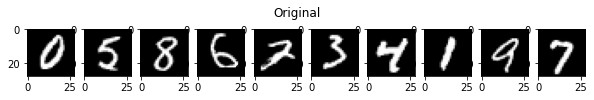

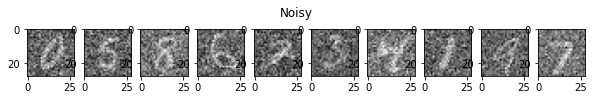

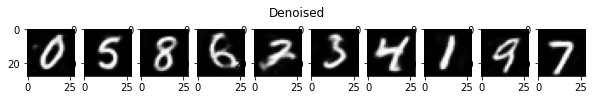

In [54]:
#4
images = [inputs, noisy_inputs, outputs]
subtitles = ["Original", "Noisy", "Denoised"]
for j in range(3):
  plt.figure(figsize=(10, 3))
  plt.gray()
  for i, image in zip(range(10) , images[j]):
    plt.subplot(3, 10, i+1)
    image = image.reshape(-1, 28,28)
    plt.imshow(torch.Tensor.cpu(image[0]))
  plt.suptitle(subtitles[j])

torch.Size([10000, 64, 1, 1])


Text(0.5, 1.0, 'PCA latent dimension reduction')

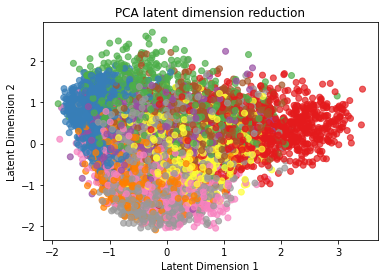

In [77]:
#5
print(latent.size())
pca = PCA(n_components=2)
pca_result = pca.fit_transform(torch.Tensor.cpu(latent.reshape(labels.shape[0],-1)))
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.7, cmap='Set1', c=labels)
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title("PCA latent dimension reduction")

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Text(0.5, 1.0, 'TSNE latent dimension reduction')

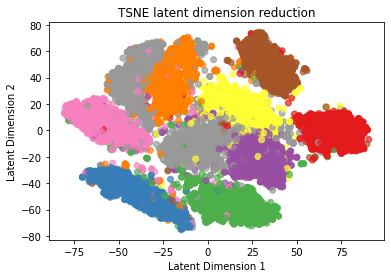

In [78]:
#6
tsne = TSNE(n_components=2)
tsne_result = tsne.fit_transform(torch.Tensor.cpu(latent.reshape(labels.shape[0],-1)))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], alpha=0.7, cmap='Set1', c=labels)
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title("TSNE latent dimension reduction")

#7)
With latent representation, we can learn about the underlying structure of the data. We can identify the patterns and relations between features and figure out wich feature has the most important role in predicting accurately and which feature should be removed to decrease the noise. PCA is a linear dimension reduction technique which attempts to preserve the global structure of data while t-SNE is a non-linear technique which attempts to preserve the local structre and can lead to better visualization for high dimensional data.